In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [33]:
df = pd.read_csv('data/set.csv')
df['class'] = df.apply(lambda row: 'HIGH' if row['shares']>=1400 else 'LOW', axis=1)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,class
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,LOW
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,LOW
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,HIGH
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,LOW
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,LOW


In [35]:
X = df.drop(['shares', 'class','url','timedelta'], axis=1)
y = df['class']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Analiza danych

## Rozkład klas

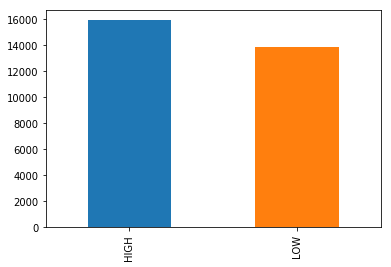

In [68]:
y_train.value_counts().plot('bar')

## Analiza PCA

In [118]:
an_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=58))
])
projected = an_pipe.fit_transform(X_train)
pca = an_pipe.named_steps['pca']

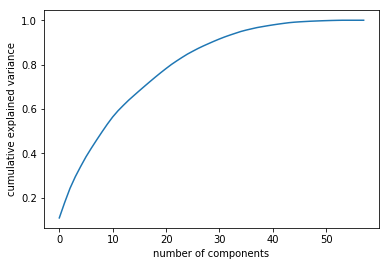

In [119]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

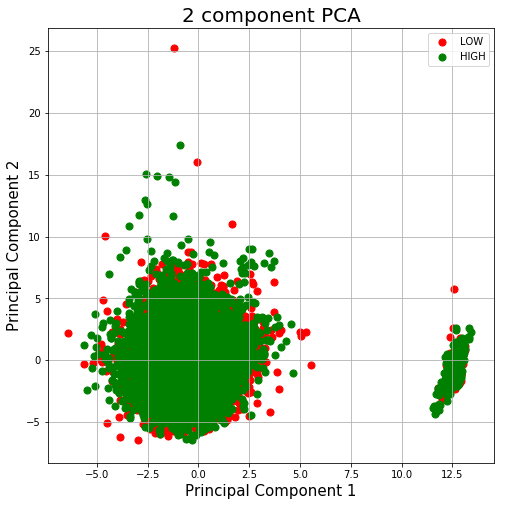

In [120]:
y_train_pca =y_train.reset_index()
pca_df = pd.DataFrame(data = projected[:,:2], columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([pca_df, y_train_pca['class']], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LOW', 'HIGH']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

(29733, 58)

# Statystyki modelu

In [44]:
def best_model_metrics(model, X_test, y_test):
    acc = model.score(X_test, y_test)
    print("acc: {:.2f}%".format(acc*100))
    
    if hasattr(model, "decision_function"):
        preds = model.decision_function(X_test)
    else:
        preds = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label='LOW')
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))    

# SVM

In [7]:
svc_parameters = [{'kernel': ['rbf'], 
                     'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]
                    },
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100, 1000]
                    }]

svc_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC())
    #('grid', GridSearchCV(estimator=SVC(), param_grid=tuned_parameters, n_jobs=-1, cv=2))
])

svc_pipe.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

acc: 65.35%


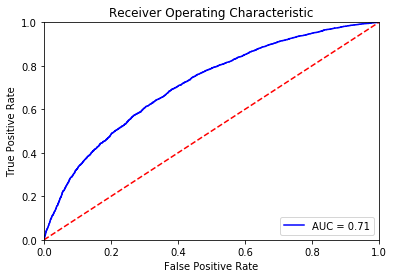

              precision    recall  f1-score   support

        HIGH       0.66      0.71      0.68      5248
         LOW       0.64      0.59      0.62      4663

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.65      0.65      0.65      9911



In [8]:
best_model_metrics(pipe, X_test, y_test)

# Regresja logistyczna

In [59]:
logit_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression(solver='lbfgs',random_state=0))
    #('grid', GridSearchCV(estimator=SVC(), param_grid=tuned_parameters2, n_jobs=-1, cv=2))
])

logit_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

acc: 65.08%


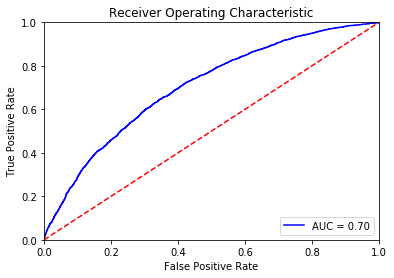

              precision    recall  f1-score   support

        HIGH       0.66      0.71      0.68      5248
         LOW       0.64      0.59      0.62      4663

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.65      0.65      0.65      9911



In [60]:
best_model_metrics(logit_pipe, X_test, y_test)

In [67]:
logit_pipe.named_steps['logit'].coef_

array([[-1.27037943e-05, -6.17717549e-02,  2.39638179e-02,
         4.13853575e-02,  9.04426880e-02, -1.01778072e-01,
         7.69877716e-02, -1.58282389e-02, -1.27597191e-03,
         7.36025849e-02, -8.17278112e-02,  4.15529371e-02,
         1.17577973e-01,  9.14075084e-02, -1.88847821e-01,
        -1.85938655e-01,  1.33764508e-02, -1.23324584e-01,
        -2.98211144e-02,  3.64282381e-02,  2.55156427e-02,
         6.92413770e-02,  7.64630177e-02,  1.24653409e-01,
         5.48722251e-01, -9.66839097e-01, -3.41427939e-02,
        -1.87289004e-03, -1.15396268e-01,  4.00024566e-03,
         5.51417492e-02,  5.96313181e-02,  3.95853043e-02,
        -3.55633102e-02, -1.22376035e-01, -7.55025243e-02,
        -1.44359066e-01, -2.11088801e-01,  6.82204139e-02,
         1.08961078e-01,  1.02432582e-01, -7.05045389e-02,
        -1.28580956e-01, -1.53716709e-02,  6.86857303e-02,
        -5.86844599e-02, -1.84318262e-01, -6.37393978e-02,
         5.05557731e-02,  3.20596845e-02,  1.61776080e-0

# Drzewo losowe

In [48]:
tree_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('tree', DecisionTreeClassifier(random_state=0))
    #('grid', GridSearchCV(estimator=SVC(), param_grid=tuned_parameters2, n_jobs=-1, cv=2))
])

tree_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])

acc: 57.75%


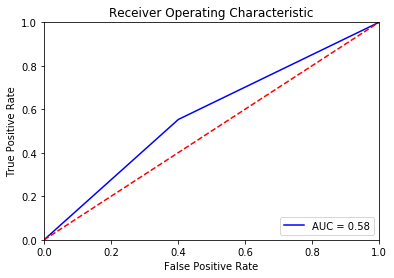

              precision    recall  f1-score   support

        HIGH       0.66      0.71      0.68      5248
         LOW       0.64      0.59      0.62      4663

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.65      0.65      0.65      9911



In [49]:
best_model_metrics(tree_pipe, X_test, y_test)

# Las Losowy

In [57]:
forest_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('forest', RandomForestClassifier())
    #('grid', GridSearchCV(estimator=SVC(), param_grid=tuned_parameters2, n_jobs=-1, cv=2))
])

forest_pipe.fit(X_train, y_train)

C:\Users\ulano\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
  ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

acc: 62.99%


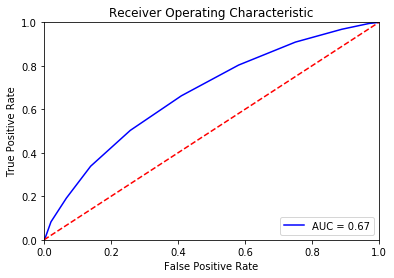

              precision    recall  f1-score   support

        HIGH       0.66      0.71      0.68      5248
         LOW       0.64      0.59      0.62      4663

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.65      0.65      0.65      9911



In [58]:
best_model_metrics(forest_pipe, X_test, y_test)

# Klasyfikator Naiwny Bayesa

In [50]:
nb_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('nb', GaussianNB())
    #('grid', GridSearchCV(estimator=SVC(), param_grid=tuned_parameters2, n_jobs=-1, cv=2))
])

nb_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nb', GaussianNB(priors=None, var_smoothing=1e-09))])

acc: 59.37%


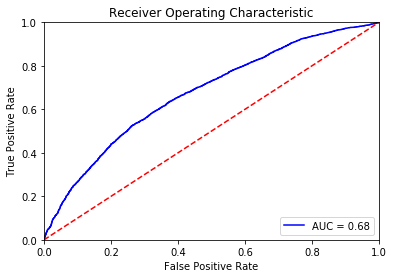

              precision    recall  f1-score   support

        HIGH       0.66      0.71      0.68      5248
         LOW       0.64      0.59      0.62      4663

   micro avg       0.65      0.65      0.65      9911
   macro avg       0.65      0.65      0.65      9911
weighted avg       0.65      0.65      0.65      9911



In [51]:
best_model_metrics(nb_pipe, X_test, y_test)